In [ ]:
from PIL import Image
from torchvision import transforms
import torch

transform = transforms.Compose(
            [transforms.ToTensor()]
        )

segmap_img_path = '/home/Lev/Projects/diffusion_finetuning/data/bin_seg_maps/2011_003271.jpg'
segmap_instance_image = Image.open(segmap_img_path)
segmap_instance_image = transform(segmap_instance_image)
print(torch.unique(segmap_instance_image))


In [5]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)


/opt/miniconda3/envs/lev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 7535.24it/s]


### Test VAE of Img2Img pipeline

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 7067.07it/s]


torch.Size([1, 3, 512, 512])


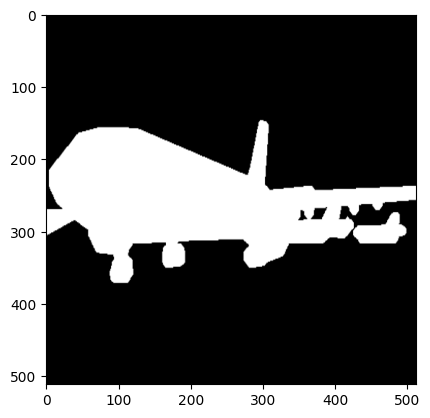

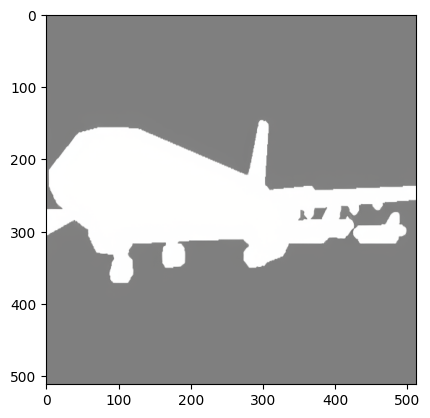

In [38]:
vae = pipe.vae.to('cuda:1')

img_transforms = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(512),
    transforms.ToTensor()]
)
plt.figure(1)
tst_img_path = "./data/bin_seg_maps/2007_000033.png"
tst_img = Image.open(tst_img_path).convert('RGB').resize([512,512])
plt.imshow(tst_img)
tst_img = img_transforms(tst_img).to('cuda:1', dtype=torch.float16)
tst_img = tst_img.unsqueeze(0)
# tst_img = torch.stack(tst_img).to(memory_format=torch.contiguous_format).float()
print(tst_img.shape)

tst_img_latents = vae.encode(tst_img).latent_dist.sample()
#decoded_img = vae.decode(tst_img_latents).sample.detach().cpu().squeeze()
decoded_img = decode_latents(vae, tst_img_latents).squeeze()
plt.figure(2)
plt.imshow(decoded_img)

In [26]:
def decode_latents(vae, latents):
        #latents = 1 / 0.18215 * latents
        image = vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        image = image.detach().cpu().permute(0, 2, 3, 1).float().numpy()
        return image

### Test Trained UNET (for segmentation)

/opt/miniconda3/envs/lev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


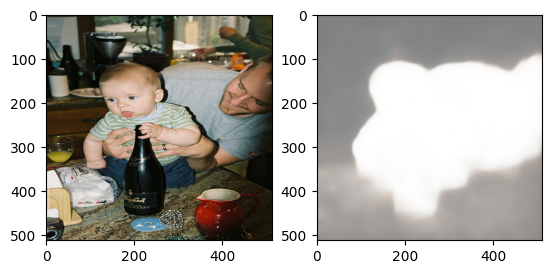

In [3]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_lora, tune_lora_scale
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import StableDiffusionImg2ImgPipeline

UNET_WEIGHTS_PATH = './output/unet_segmentation_mse_loss_train_split/unet_seg_weights.pt'
LORA_WEIGHTS_PATH = './output/unet_segmentation_mse_loss_train_split/lora_weight.pt'

model_id = "stabilityai/stable-diffusion-2-1-base"
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda:1')

monkeypatch_lora(pipe.unet, torch.load(LORA_WEIGHTS_PATH))
tune_lora_scale(pipe.unet, 1.2)
replace_unet_in_pipeline(pipe, UNET_WEIGHTS_PATH, device=pipe.device)

tst_img_path = "./data/original_test/2007_001408.jpg"
tst_img = Image.open(tst_img_path).convert('RGB').resize([512,512])
# plt.figure(1)
# plt.imshow(tst_img)

prompt="segmentation map"
img = pipe(prompt=prompt, image=tst_img, strength=0.1, guidance_scale=5, modified_unet=True, segmentation=True).images[0]
# plt.figure(2)
# plt.imshow(img)

fig, axs = plt.subplots(1,2)
axs[0].imshow(tst_img)
axs[1].imshow(img)
plt.show()

In [4]:
pipe.unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Linear(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (attn1): CrossAttention(
                (to_q): LoraInjectedLinear(
                  (linear): Linear(in_features=320, out_features=320, bias=False)
                  (lora_down): Linear(in_features=320, out_features=4, bias=False)
                  (lora_up): Linear(in_features=4, out_features=320, bias=Fals

In [9]:
diffuse_random_imgs('./data/original_test/', pipe,"segmentation map", 0.1, 5)

TypeError: Random.sample() got an unexpected keyword argument 'figsize'

In [2]:
def replace_unet_in_pipeline(pipe, path_to_weights=None, device='cuda'):
    unet = pipe.unet
    tmp = unet.conv_out
    n_noise_pred_channels = unet.conv_out.out_channels

    new_layer =  torch.nn.Conv2d(tmp.in_channels, tmp.out_channels * 2, kernel_size=tmp.kernel_size, padding=tmp.padding, bias=True, dtype=torch.float16) # Add 2 channels to serve for segmentation
    if path_to_weights:
        # load weights
        chkpt = torch.load(path_to_weights)
        new_layer.load_state_dict(chkpt['conv_out_state_dict'])
    else:
        # init weights to pipe weights
        new_layer.weight.data[:tmp.weight.data.shape[0], :, :, :] = tmp.weight.data[:, :, :, :]
    new_layer.to(device=device)
    unet.conv_out = new_layer
    return

In [10]:
# Sample random pics and get their seg
from os import walk
import random

def diffuse_random_imgs(img_folder, pipe, prompt, strength, guidance,neg_prompt=None, save_path=None):
    N_PICS = 9
    f = next(walk(img_folder), (None, None, []))[2]
    filenames = [os.path.join(img_folder, filename) for filename in f]
    filenames = random.sample(filenames, N_PICS)

    fig , ax = plt.subplots(N_PICS, 2,figsize=(128, 128))
    for i, f in enumerate(filenames):
        init_image = Image.open(f).convert("RGB").resize((512, 512))
        ax[i, 0].imshow(init_image, aspect='auto')
        ax[i, 0].axis('off')
        image = pipe(prompt=prompt, image=init_image, strength=strength, guidance_scale=guidance, modified_unet=True, segmentation=True).images[0]
        ax[i, 1].imshow(image, aspect='auto')
        ax[i, 1].axis('off')

        if save_path:
            if not os.path.exists(save_path):       
                os.mkdir(save_path)
            init_image.save(os.path.join(save_path, 'original_' + os.path.basename(f)))
            image.save(os.path.join(save_path, os.path.basename(f)))

    plt.show()



SyntaxError: invalid syntax (2585573177.py, line 11)